In [16]:
import math
import random
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

# The Idea Behind Gradient Descent
In calculus, the _gradient_ is the vector of partial derivatives and it identifies the direction of inputs that increase the functions outputs most quickly.

We can use gradient descent to maximize a function by starting at a random point and moving in the direction of the gradient--then repeat.

# Estimating The Gradient
The derivative of $f(x)$ measures how $f(x)$ changes when making very small changes to $x$:

In [1]:
def difference_quotient(f, x, h):
    return (f(x + h) - f(x)) / h

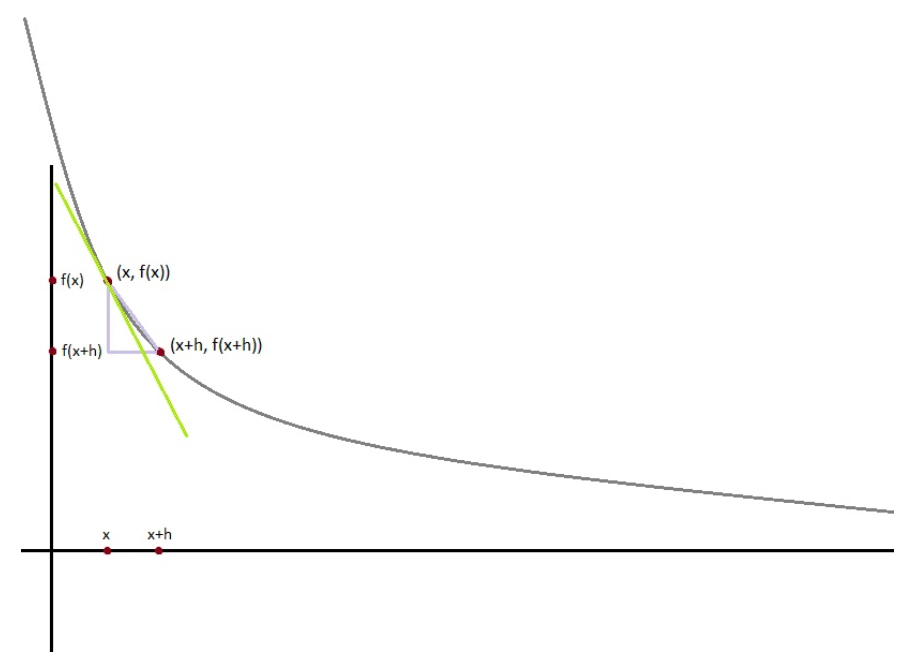

It is the slope of the tangent line at $(x,\ f(x))$ that tells us which direction to traverse. As $h$ gets smaller, the bottom tail of the line gets close to the curve.

In [10]:
def square(x):
    return x * x

def derivative(x):
    return 2 * x

derivative(2)

4

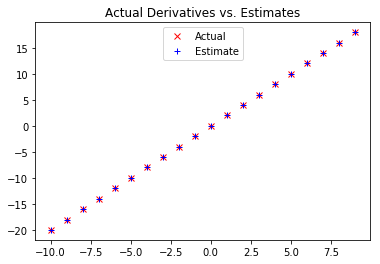

In [11]:
derivative_estimate = partial(difference_quotient, square, h=0.00001)

x = range(-10,10)
plt.title("Actual Derivatives vs. Estimates")
plt.plot(x, [derivative(x_i) for x_i in x], 'rx', label='Actual') # red x
plt.plot(x, [derivative_estimate(x_i) for x_i in x], 'b+', label='Estimate') # blue +
plt.legend(loc=9)
plt.show()

# Using The Gradient
Here is an example of using gradient descent to find the minimum of a 3-dimensional vector:

In [28]:
def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def vector_subtract(v, w):
    """subtracts corresponding elements"""
    return [v_i - w_i for v_i, w_i in zip(v, w)]

def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def squared_distance(v, w):
    """(v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(vector_subtract(v, w))

def distance(v, w):
    return math.sqrt(squared_distance(v, w))

def step(v, direction, step_size):
    """move step_size in the direction from v"""
    return [v_i + step_size * direction_i for v_i, direction_i in zip(v, direction)]

def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]

# pick a random starting point
v = [random.randint(-10,10) for i in range(3)]

tolerance = 0.0001

while True:
    gradient = sum_of_squares_gradient(v) # compute the gradient at v
    next_v = step(v, gradient, -0.01) # take a negative gradient step
    if distance(next_v, v) < tolerance: # stop if we're converging
        break
    v = next_v # continue if we're not
v

[0.002835423996751396, 0.003969593595451951, -0.0005670847993502782]

# Choose The Right Step Size
Although using the right step size is important, there is not an exact way to know which size to use. Some general rules of thumb are:
- use a fixed step size.
- gradually shrink the step size over iterations.
- finding the step size that leads to the minimum at each step.

We can illustrate this last point with an example:

In [29]:
step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

Some step sizes provide invalid inputs to our function so we will need a safe version:

In [30]:
def safe(f):
    """return a new function that's the same as f,
    except that it outputs infinity whenever f produces an error"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf') # this means "infinity" in Python
    return safe_f

# Putting It All Together
Given a target function that we want to minimize, and given a gradient function, we can determine the parameters that minimize the error:

In [31]:
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""
    
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    
    theta = theta_0 # set theta to initial value
    target_fn = safe(target_fn) # safe version of target_fn
    value = target_fn(theta) # value we're minimizing
    
    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size) for step_size in step_sizes]
        
        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)
        
        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value

Another optimization involves _maximizing_ a function by minimizing its negative:

In [32]:
def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0,
                          tolerance)

# Stochastic Gradient Descent
The approach above is computationally expensive: the gradient is computed for the whole dataset. A more efficient approach would be to compute the gradient for one point at a time. This is what _stochastic gradient descent_ does. It will run over our data--each point individually--until the stopping point which we define.

Best results can be achieved by selecting our data at random:

In [33]:
def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)] # create a list of indexes
    random.shuffle(indexes) # shuffle them
    for i in indexes: # return the data in that order
        yield data[i]

In order that we don't get stuck in an infinite cycle, we need to decrease the step size and quit once minimizations to the error stop improving:

In [2]:
def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
#     print('Calculating gradient for x=', x)
    theta = theta_0 # initial guess
    alpha = alpha_0 # initial step size
    min_theta, min_value = None, float('inf') # the minimum so far
    iterations_with_no_improvement = 0
    
    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        def to_sum(x_i, y_i):
#             print('x_i={}, y_i={}, theta={}'.format(x_i, y_i, theta))
            return target_fn(x_i, y_i, theta)
        value = sum([to_sum(x_i, y_i) for x_i, y_i in zip(x, y)])
        
        if value < min_value:
#             print('value={}, min_value={}'.format(value, min_value))
            # if we've found a new minimum, remember it and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
#             print('no improvement, i={}, alpha={}'.format(iterations_with_no_improvement, alpha))
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9
            
        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(list(zip(x, y))):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))
#             print('Gradient step: gradient_i={}, theta={}'.format(gradient_i, theta))
    
    return min_theta

Stochastic gradient descent is a lot faster than our first version. Here is a negated version:

In [3]:
def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn), negate_all(gradient_fn), x, y, theta_0, alpha_0)